# Project work: A mini segmentation challenge

Imaging for the Life Sciences  
MSLS / CO4: Project work

**Student**: $\Rightarrow$  Guansheng Du    
**University**: $\Rightarrow$  ZHAW  
**Semester**: $\Rightarrow$  SS24   
**Date**: $\Rightarrow$  DATE OF SUBMISSION 



## Dataset 

[https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)

<br><br><br>
## Table of contents
<!-- Unfortunately, the following does not always work correctly -->
* [1. Dataset](#sec_dataset)  
* [2. Preprocessing](#sec_preprocessing)  
* [3. Manual segmentation](#sec_manual_segmentation)  
* [4. Automated segmentation](#sec_automated_segmentation)  
* [5. Evaluation](#sec_evaluation)  
* [6. Discussion](#sec_discussion)  
* [*. Hints](#sec_hints)  


---

## Prerequisites / Setup

$\Rightarrow$  Special setup instructions, imports and configurations go here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import nibabel as nib
import pydicom
import PIL

# Jupyter / IPython configuration:
# Automatically reload modules when modified
%load_ext autoreload
%autoreload 2

# Enable vectorized output (for nicer plots)
%config InlineBackend.figure_formats = ["svg"]

# Inline backend configuration
%matplotlib inline

# Enable this line if you want to use the interactive widgets
# It requires the ipympl package to be installed.
#%matplotlib widget

import sys
sys.path.insert(0, "../")
import tools

data_folder = '/home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/raw/'



---


<a id='sec_dataset'></a>

## Dataset

$\Rightarrow$ Describe your dataset.

### Requirements:
* Dataset of at least 10 image samples
* The data set must not be larger than 200 MB. If your data is larger, please contact the tutor.
* Make sure you have the right to use the data and share it with others (check the usage license!)
* A structure of interest should be easily recognizable in these samples
* Avoid data with too much variation
* All students will use different datasets!


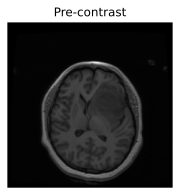

In [2]:
# Read in sample .tif image with pre-contrast and post-contrast channels 

image = PIL.Image.open(
    data_folder + "TCGA_HT_A61A_20000127_43.tif"
)

# Split the image into individual bands
channels = image.split()

# Access each channel individually
pre_contrast = channels[0]
FLAIR = channels[1]
post_contrast = channels[2]

# Display the pre-contrast channel
plt.figure(figsize=(3, 3))
plt.imshow(pre_contrast, cmap="gray")
plt.title("Pre-contrast")
plt.axis("off")
plt.show()



(-0.5, 255.5, 255.5, -0.5)

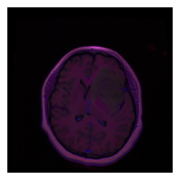

In [3]:
plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.axis("off")

In [4]:
%%capture

# Read in sample .tif image with pre-contrast and post-contrast channels

image = PIL.Image.open(
    data_folder + "TCGA_HT_A61B_19991127_34.tif"
)


# Split the image into individual bands
channels = image.split()

# Access each channel individually
pre_contrast = channels[0]
FLAIR = channels[1]
post_contrast = channels[2]

# Display the pre-contrast channel
plt.figure(figsize=(5, 5))
plt.imshow(pre_contrast, cmap="gray")
plt.title("Pre-contrast")
plt.show()

# Display the FLAIR channel
plt.figure(figsize=(5, 5))
plt.imshow(FLAIR, cmap="gray")
plt.title("FLAIR")
plt.show()

# Display the post-contrast channel
plt.figure(figsize=(5, 5))
plt.imshow(post_contrast, cmap="gray")
plt.title("Post-contrast")
plt.show()

---

<a id='sec_preprocessing'></a>

## Preprocessing

$\Rightarrow$ Describe the pre-processing that was required to complete the segmentation task.


### Goals:
* Choose a method that scales well for larger datasets
* Improve the datasets for easier processing

In [5]:
# Function to sort filenames in natural order
# Generated by AI

import re

def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)



In [6]:
import os
import pandas as pd

# Get a list of all .tif files in the data folder
tif_files = [f for f in os.listdir(data_folder) if f.endswith(".tif")]

# Usage:
tif_files = natural_sort(tif_files)
tif_files

['TCGA_CS_4941_19960909_1.tif',
 'TCGA_CS_4941_19960909_1_mask.tif',
 'TCGA_CS_4941_19960909_2.tif',
 'TCGA_CS_4941_19960909_2_mask.tif',
 'TCGA_CS_4941_19960909_3.tif',
 'TCGA_CS_4941_19960909_3_mask.tif',
 'TCGA_CS_4941_19960909_4.tif',
 'TCGA_CS_4941_19960909_4_mask.tif',
 'TCGA_CS_4941_19960909_5.tif',
 'TCGA_CS_4941_19960909_5_mask.tif',
 'TCGA_CS_4941_19960909_6.tif',
 'TCGA_CS_4941_19960909_6_mask.tif',
 'TCGA_CS_4941_19960909_7.tif',
 'TCGA_CS_4941_19960909_7_mask.tif',
 'TCGA_CS_4941_19960909_8.tif',
 'TCGA_CS_4941_19960909_8_mask.tif',
 'TCGA_CS_4941_19960909_9.tif',
 'TCGA_CS_4941_19960909_9_mask.tif',
 'TCGA_CS_4941_19960909_10.tif',
 'TCGA_CS_4941_19960909_10_mask.tif',
 'TCGA_CS_4941_19960909_11.tif',
 'TCGA_CS_4941_19960909_11_mask.tif',
 'TCGA_CS_4941_19960909_12.tif',
 'TCGA_CS_4941_19960909_12_mask.tif',
 'TCGA_CS_4941_19960909_13.tif',
 'TCGA_CS_4941_19960909_13_mask.tif',
 'TCGA_CS_4941_19960909_14.tif',
 'TCGA_CS_4941_19960909_14_mask.tif',
 'TCGA_CS_4941_19960909_

In [7]:
mask_files = [f for f in tif_files if "_mask" in f]
len(mask_files)

3929

In [8]:
image_files = [f for f in tif_files if "_mask" not in f]
len(image_files)


3929

In [9]:
# Create a DataFrame
df = pd.DataFrame({"image_file": image_files, "mask_file": mask_files})
df.head()

,image_file,mask_file
0,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif
1,TCGA_CS_4941_19960909_2.tif,TCGA_CS_4941_19960909_2_mask.tif
2,TCGA_CS_4941_19960909_3.tif,TCGA_CS_4941_19960909_3_mask.tif
3,TCGA_CS_4941_19960909_4.tif,TCGA_CS_4941_19960909_4_mask.tif
4,TCGA_CS_4941_19960909_5.tif,TCGA_CS_4941_19960909_5_mask.tif


In [10]:
from PIL import Image
import numpy as np

df['mask_path'] = df.mask_file.apply(lambda x: data_folder + x)
df['image_path'] = df.image_file.apply(lambda x: data_folder + x)

df.head()

,image_file,mask_file,mask_path,image_path
0,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
1,TCGA_CS_4941_19960909_2.tif,TCGA_CS_4941_19960909_2_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
2,TCGA_CS_4941_19960909_3.tif,TCGA_CS_4941_19960909_3_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
3,TCGA_CS_4941_19960909_4.tif,TCGA_CS_4941_19960909_4_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
4,TCGA_CS_4941_19960909_5.tif,TCGA_CS_4941_19960909_5_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...


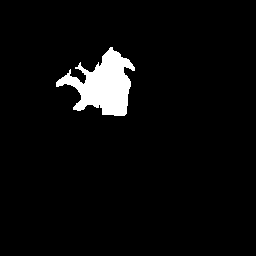

In [11]:
Image.open(df["mask_path"][12])

In [12]:
from PIL import Image
import numpy as np


def check_mask(file):
    # Open the file
    image = Image.open(file)

    # Convert the image to an array
    image_array = np.array(image)

    # Check if there is a white pixel
    if np.any(image_array > 0):
        return 1
    else:
        return 0



In [13]:
df["check_mask"] = df["mask_path"].apply(check_mask)

df.head()

,image_file,mask_file,mask_path,image_path,check_mask
0,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
1,TCGA_CS_4941_19960909_2.tif,TCGA_CS_4941_19960909_2_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
2,TCGA_CS_4941_19960909_3.tif,TCGA_CS_4941_19960909_3_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
3,TCGA_CS_4941_19960909_4.tif,TCGA_CS_4941_19960909_4_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
4,TCGA_CS_4941_19960909_5.tif,TCGA_CS_4941_19960909_5_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0


In [14]:
%%capture

import numpy as np
import matplotlib.pyplot as plt

import torch

np.random.seed(42)

# Generate 16 random indices
indices = np.random.randint(0, len(df), 16)

# Create a figure for the subplots
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

# Loop over the indices
for i, index in enumerate(indices):
    # Read the image and mask
    image = Image.open(df.loc[index, "image_file"])
    mask = Image.open(df.loc[index, "mask_file"])

    # Create a subplot for the image and mask
    ax = axs[i // 4, i % 4]
    ax.imshow(image, cmap="gray")
    ax.imshow(mask, cmap="jet", alpha=0.5)  # Overlay the mask on the image
    ax.axis("off")
    
    mask_status = "Mask" if df.loc[index, "check_mask"] == 1 else "No mask"
    ax.set_title(f"Index: {index}\n{mask_status}")


plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'TCGA_HT_7692_19960724_11.tif'

In [15]:
np.random.randint(0, len(df), 16)


array([3171, 2919, 3735,  130, 1685, 3380,  769, 2391, 1515, 3485, 2853,
       2433, 1215,  955, 2324, 1184])

In [16]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms

data_transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomApply([transforms.RandomRotation(degrees=90)], p=0.5),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
    ]
)

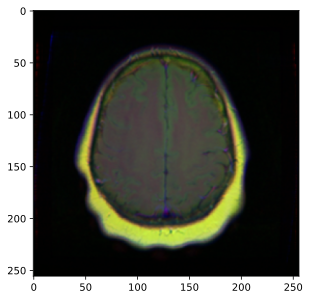

In [17]:
image = Image.open(df["image_path"][37])
plt.imshow(image)


(-0.5, 127.5, 127.5, -0.5)

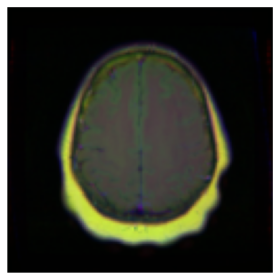

In [18]:

image2 = data_transform(image)
plt.imshow(image2.permute(1, 2, 0))
plt.axis("off")

In [19]:
def show_aug(inputs, nrows=1, ncols=1, norm=False):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    i_ = 0

    if len(inputs) > 25:
        inputs = inputs[:25]

    for idx in range(len(inputs)):

        # normalization
        if norm:
            img = inputs[idx].numpy().transpose(1, 2, 0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            img = (img * std + mean).astype(np.float32)

        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0, :, :]

        plt.subplot(nrows, ncols, i_ + 1)
        plt.imshow(img)
        plt.axis("off")

        i_ += 1

    return plt.show()

In [20]:
%%capture

np.random.seed(42)

# Generate 16 random indices
indices = np.random.randint(0, len(df), 16)

# Create a figure for the subplots
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

# Loop over the indices
for i, index in enumerate(indices):
    # Read the image and mask
    image = Image.open(df.loc[index, "image_file"])
    # mask = Image.open(df.loc[index, "mask_file"])
    image = transforms(image=np.array(image))["image"]

    # Create a subplot for the image and mask
    ax = axs[i // 4, i % 4]

    ax.imshow(image)
    # ax.imshow(mask, cmap="jet", alpha=0.5)  # Overlay the mask on the image
    ax.axis("off")

    mask_status = "Mask" if df.loc[index, "check_mask"] == 1 else "No mask"
    ax.set_title(f"Index: {index}\n{mask_status}")

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'TCGA_HT_7692_19960724_11.tif'

---

<a id='sec_manual_segmentation'></a>

## Manual segmentation

$\Rightarrow$ Describe the manual segmentation step


### Goals:
* Segment structures of interest using a tool  
* These structures you need to 
* If you find a dataset that comes with segmentation masks, you still need to demonstrate how to create such masks!

---

<a id='sec_automated_segmentation'></a>

## Automated segmentation

$\Rightarrow$ Describe how to segment the image in Python


### Goals:
* The segmentation must be performed in Python.
* Using an external library or tool (e.g. OpenCV) is permitted.
* Implement a function `segment(image, ...)` takes an image as input and creates a segmentation mask for the structure of interest.

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
df.head()

,image_file,mask_file,mask_path,image_path,check_mask
0,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
1,TCGA_CS_4941_19960909_2.tif,TCGA_CS_4941_19960909_2_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
2,TCGA_CS_4941_19960909_3.tif,TCGA_CS_4941_19960909_3_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
3,TCGA_CS_4941_19960909_4.tif,TCGA_CS_4941_19960909_4_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
4,TCGA_CS_4941_19960909_5.tif,TCGA_CS_4941_19960909_5_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0


In [24]:
# train_df = df.sample(frac=0.8, random_state=42)
# test_df = df.drop(train_df.index)


df_mask = df[df["check_mask"] == 1]
train_df = df_mask.sample(frac=0.8, random_state=42)
test_df = df_mask.drop(train_df.index)


train_df.shape, test_df.shape

((1098, 5), (275, 5))

In [31]:
df_mask.head()

,image_file,mask_file,mask_path,image_path,check_mask
10,TCGA_CS_4941_19960909_11.tif,TCGA_CS_4941_19960909_11_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,1
11,TCGA_CS_4941_19960909_12.tif,TCGA_CS_4941_19960909_12_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,1
12,TCGA_CS_4941_19960909_13.tif,TCGA_CS_4941_19960909_13_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,1
13,TCGA_CS_4941_19960909_14.tif,TCGA_CS_4941_19960909_14_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,1
14,TCGA_CS_4941_19960909_15.tif,TCGA_CS_4941_19960909_15_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,1


In [32]:
from PIL import Image

import torch
from torch.utils.data import Dataset
import random

class CustomImageDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def load_image(self, idx):
        image = Image.open(self.df.iloc[idx, "image_path"])
        mask = Image.open(self.df.iloc[idx, "mask_path"])
        return image, mask

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.df["image_path"].iloc[idx]
        mask_name = self.df["mask_path"].iloc[idx]

        image = Image.open(img_name)
        mask = Image.open(mask_name)
        
        image, mask = self.transforms(image, mask)


        return image, mask

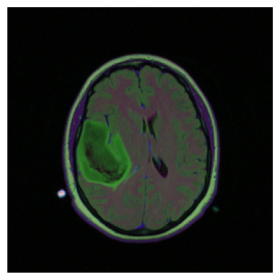

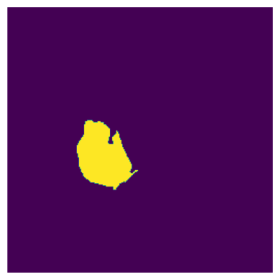

In [28]:
image = plt.imread(train_df.iloc[16]["image_path"])
mask = plt.imread(train_df.iloc[16]["mask_path"]) 


plt.imshow(image)
plt.axis("off")
plt.show()

plt.imshow(mask)
plt.axis("off")
plt.show()



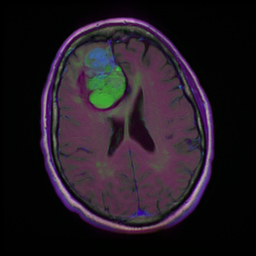

In [29]:
Image.open(train_df.iloc[10]["image_path"])


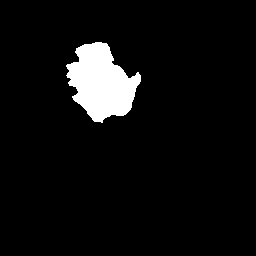

In [30]:

Image.open(train_df.iloc[10]["mask_path"])


In [33]:

train_dataset = CustomImageDataset(train_df, transforms=data_transform)
test_dataset = CustomImageDataset(test_df, transforms=data_transform)


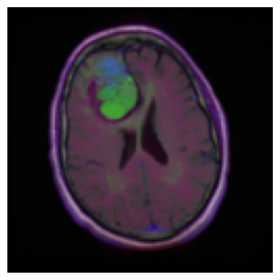

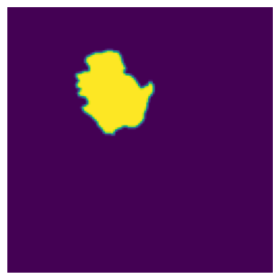

In [34]:
image, mask = train_dataset[10]

plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.show()

plt.imshow(mask.permute(1, 2, 0))
plt.axis("off")
plt.show()

In [35]:
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7fd06a82e650>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd06a859a90>)

In [36]:
image, mask = next(iter(train_loader))
image.shape, mask.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16, 1, 128, 128]))

In [37]:
os.cpu_count()

6

In [38]:
train_df["image_path"].iloc[0]

'/home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/raw/TCGA_DU_7014_19860618_27.tif'

In [39]:
train_df.iloc[0, train_df.columns.get_loc("image_path")]


'/home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/raw/TCGA_DU_7014_19860618_27.tif'

In [40]:
train_dataset[0][0]

Image([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

       [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
        [0.0000, 0.0039, 0.0039,  ..., 0.0078, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0078,  ..., 0.0078, 0.0078, 0.0000],
        [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

       [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ..

/home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/raw/TCGA_DU_7014_19860618_27.tif


(-0.5, 127.5, 127.5, -0.5)

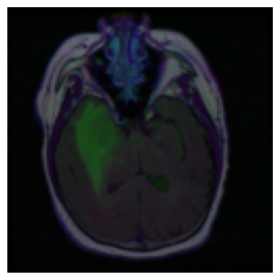

In [41]:
print(train_df.iloc[0]['image_path'])
plt.imshow(train_dataset[0][0].permute(1, 2, 0))
plt.axis("off")


In [42]:
import torch.nn as nn

class UNet(nn.Module):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        ).to(device)

        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        ).to(device)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1),
        ).to(device)

    def forward(self, x):
        x = x.to(device)
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        y = self.decoder(x2)
        return y


model = UNet().to(device)

model(image).shape

torch.Size([16, 1, 64, 64])

In [43]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()  # Suitable for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

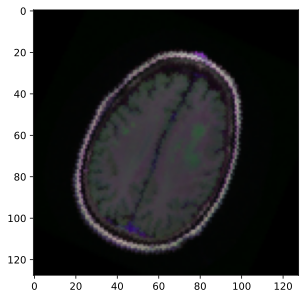

In [44]:
plt.imshow(image[0].permute(1, 2, 0))

In [45]:
mask_t = model(image.to(device))



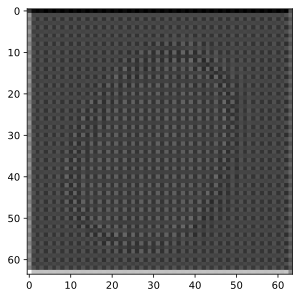

In [46]:
plt.imshow(mask_t[0].detach().cpu().numpy().squeeze(), cmap="gray")

Epoch 1/20, Loss: 0.0572


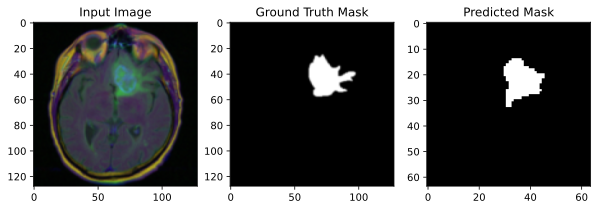

Epoch 2/20, Loss: 0.0546
Epoch 3/20, Loss: 0.0533
Epoch 4/20, Loss: 0.0523
Epoch 5/20, Loss: 0.0530
Epoch 6/20, Loss: 0.0513


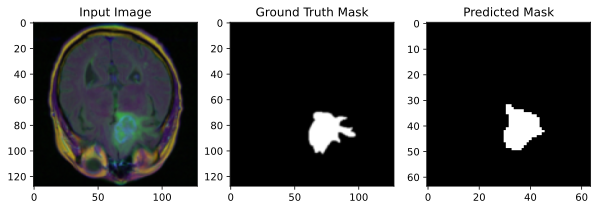

Epoch 7/20, Loss: 0.0500
Epoch 8/20, Loss: 0.0484
Epoch 9/20, Loss: 0.0489
Epoch 10/20, Loss: 0.0464
Epoch 11/20, Loss: 0.0470


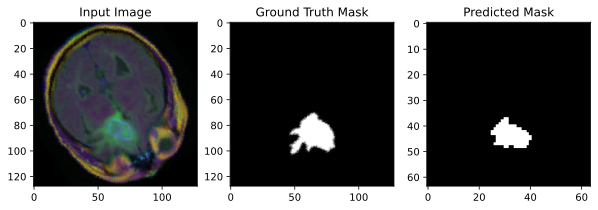

Epoch 12/20, Loss: 0.0474
Epoch 13/20, Loss: 0.0463
Epoch 14/20, Loss: 0.0453
Epoch 15/20, Loss: 0.0447
Epoch 16/20, Loss: 0.0444


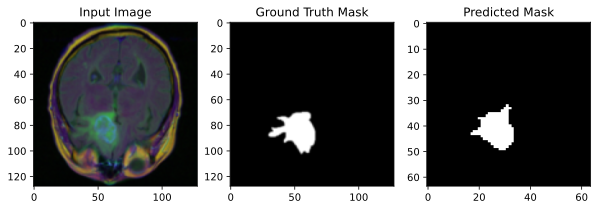

Epoch 17/20, Loss: 0.0438
Epoch 18/20, Loss: 0.0418
Epoch 19/20, Loss: 0.0429
Epoch 20/20, Loss: 0.0413


In [51]:
num_epochs = 20

torch.manual_seed(42)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        optimizer.zero_grad()
        
        images.to(device)
        masks.to(device)

        outputs = model(images)
        # Resize masks to match the size of outputs
        masks = torch.nn.functional.interpolate(masks, size=outputs.size()[2:], mode='bilinear', align_corners=False).to(device)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    if epoch % 5 == 0:

        model.eval()
        with torch.no_grad():
            for images, masks in test_loader:
                outputs = model(images)
                preds = torch.sigmoid(outputs)
                preds = preds > 0.5  # Apply threshold

                # Visualization code (for example purposes, visualize the first batch)
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(transforms.ToPILImage()(images[0].cpu()))
                plt.title("Input Image")

                plt.subplot(1, 3, 2)
                plt.imshow(transforms.ToPILImage()(masks[0].cpu()), cmap="gray")
                plt.title("Ground Truth Mask")

                plt.subplot(1, 3, 3)
                plt.imshow(preds[0].cpu().numpy().squeeze(), cmap="gray")
                plt.title("Predicted Mask")

                plt.show()
                break

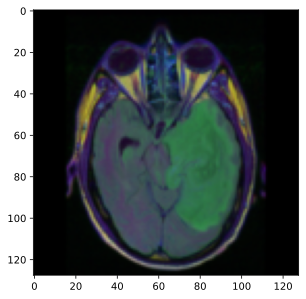

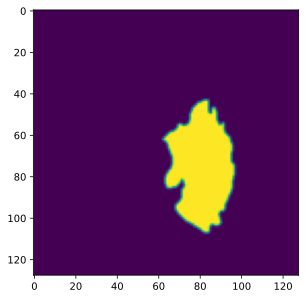

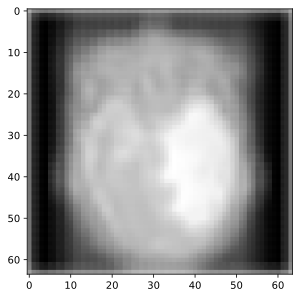

In [52]:
image, mask = next(iter(test_loader))

plt.imshow(image[8].permute(1, 2, 0))
plt.show()

plt.imshow(mask[8].permute(1, 2, 0))
plt.show()

image_t = model(image)
plt.imshow(image_t[8].detach().cpu().numpy().squeeze(), cmap="gray")



---

<a id='sec_evaluation'></a>

## Evaluation

$\Rightarrow$ Describe the evaluation of your results


### Goals:
* Choose an evaluation method that can compare two binary segmentation masks and computes a numeric score that describes how well these masks match (use for example the Dice score)
* Hint: specify a function `evaluate(mask1, mask2)` that computes the evaluation score(s)
* Compute mean and standard deviation of the scores of the entire dataset

---

<a id='sec_discussion'></a>

## Discussion

$\Rightarrow$ Discuss your results and experiences briefly.




---

<a id='sec_references'></a>

## References

$\Rightarrow$ Add here references as URLs.

Also declare the usage of **generative AI** here!!




<br><br><br><br><br><br><br><br>

---

<a id='sec_hints'></a>

## Hints:
* Display your data if possible.
* An easy way to show 2D images is using Pillow:


In [ ]:
# Displayin an image with Pillow
path = "../data/images/kidney-cells.jpg"
path = "../data/images/histology-image.jpg"
image = PIL.Image.open(path)
display(image)                  

In [ ]:
# If you keep the data as a numpy array (for example when using
# the OpenCV interface), you can use matplotlib to display it.
path = "../data/images/ct-brain-slices.jpg"
image = cv.imread(path)
plt.imshow(image)
plt.axis("off");


In [ ]:
# For convenience, we also provide tools.display_image()
path = "../data/images/kidney-cells.jpg"
tools.display_image(path, scale=0.5)

There are many ways how to overlay an image with the mask. Here is one option:

In [ ]:
# Enforce a (3-channel) color image
path_image = "../data/images/neurons-cultured.jpg"
image = cv.imread(path_image, cv.IMREAD_COLOR)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Mask image
path_mask = "../data/images/neurons-cultured-mask.png"
mask = cv.imread(path_mask, cv.IMREAD_GRAYSCALE)

# Create overlay (RGB)
overlay_color = [255, 0, 0]
overlay_alpha = 0.3
overlay = image.copy()
overlay[mask > 0] = overlay_color
overlay = cv.addWeighted(image, 1 - overlay_alpha, overlay, overlay_alpha, 0)

# Display the images next to each other using a convenience function
tools.show_image_chain((image, overlay), titles=("Input", "Overlay"))


In [ ]:
# We could also create contours around the mask and display them
overlay_color = [255, 255, 0]
line_width = 1
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
image_contours = image.copy()
cv.drawContours(image_contours, contours, -1, overlay_color, line_width)
tools.show_image_chain((image, image_contours), titles=("Input", "Contours"))

An advanced example: We can colorize the different contours with different colors.

Strategy:
- Use connected components to label the different regions using integers 
(every region has a different label)
- Assign a different color to different labels by encoding the label in 
the hue channel (HSV color space!)
- Extract contours from the mask (must be a binary image)
- Merge draw the contours with the colorized labels onto the original image

In [ ]:
# This will contain the result
image_contours = image.copy()

# Compute the "connected components" (= separate objects in the mask)
n_labels, labels = cv.connectedComponents(mask)

# Assign a different color to each label in the hue channel (HSV color space)
hue = np.uint8(150*labels/np.max(labels))
blank = 255*np.ones_like(hue)
labels = cv.merge([hue, blank, blank])

# Convert from HSV color space to RGB
labels = cv.cvtColor(labels, cv.COLOR_HSV2RGB)
# Set the background label (labels==0) to black
labels[labels==0] = 0

# Create a mask of the contours
line_width = 1
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
mask_contours = cv.drawContours(np.zeros_like(mask), contours, -1, 255, line_width)

# Assign the colored labels only along the contours
image_contours[mask_contours>0] = labels[mask_contours>0]

# Display the result
tools.show_image_chain((image, image_contours), titles=("Input", "Labeled contours"))

### How to convert a Jupyter notebook into a PDF:

- Don't forget to save this notebook before converting!
- Install nbconvert: `pip install nbconvert`
- Convert the notebook into a HTML file: `jupyter nbconvert --to html main.ipynb`  
  The file will be saved in the same folder as this Jupyter notebook
- Open the HTML in a browser and print (or save) it as a PDF
- Recommendation: If you use the Opera browser, you can save the HTML as single-page PDF. This looks the best!

In [ ]:
# Make sure you save this notebook, otherwise the HTML 
# output will not contain the latest version!!

# Make sure you have nbcovnert installed
!pip install nbconvert --quiet
# Save the notebook as HTML
!jupyter nbconvert --to html main.ipynb
